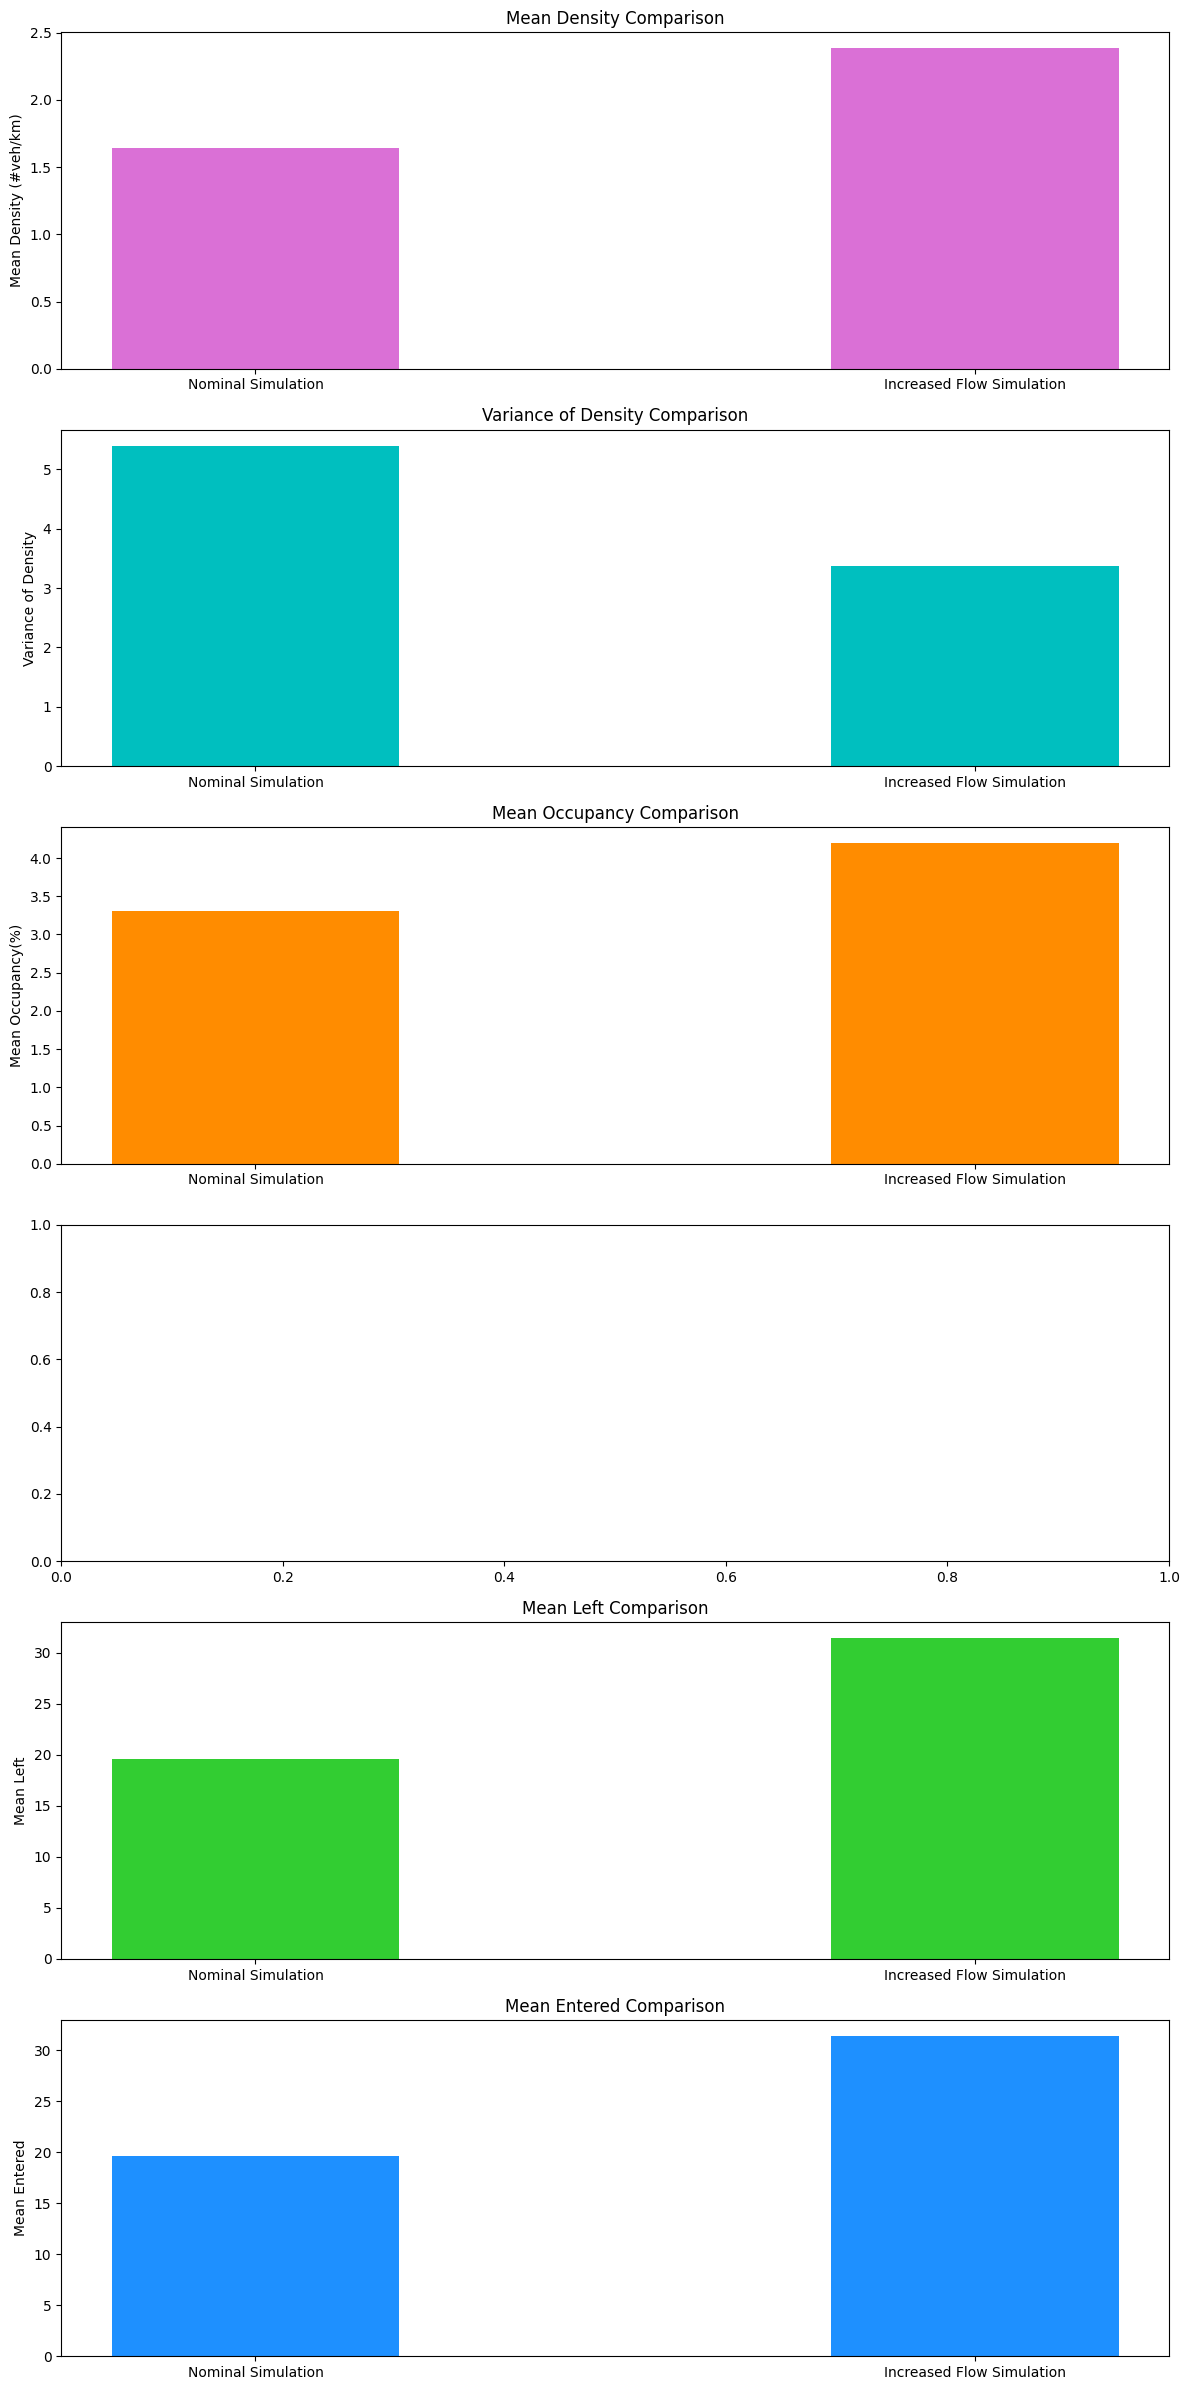

In [1]:
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt

# Function to extract edge IDs for specific zones from the districts.taz file
def extract_edges_for_zones(filename, zone_ids):
    edge_ids = set()
    with open(filename, 'r') as file:
        for line in file:
            for zone_id in zone_ids:
                if f'id="{zone_id}"' in line:
                    edges = line.split('edges="')[1].split('"')[0].split()
                    edge_ids.update(edges)
    return edge_ids

# Function to extract attributes for each edge ID from the output file
def extract_edge_data(edge_ids, output_filename, start_time, end_time):
    edge_data = {}
    tree = ET.parse(output_filename)
    root = tree.getroot()
    for interval in root.findall('interval'):
        interval_start = interval.attrib['begin']
        interval_end = interval.attrib['end']
        
        # Only process intervals within the specified time range (16:00:00 to 18:00:00)
        if interval_start >= start_time and interval_end <= end_time:
            for edge in interval.findall('edge'):
                edge_id = edge.attrib['id']
                if edge_id in edge_ids:
                    density = float(edge.attrib.get('density', 0))
                    occupancy = float(edge.attrib.get('occupancy', 0))
                    speed = float(edge.attrib.get('speed', 0))
                    left = int(edge.attrib.get('left', 0))
                    entered = int(edge.attrib.get('entered', 0))
                    if edge_id not in edge_data:
                        edge_data[edge_id] = {
                            'density': [], 'occupancy': [], 
                            'speed': [], 'left': [], 'entered': []
                        }
                    edge_data[edge_id]['density'].append(density)
                    edge_data[edge_id]['occupancy'].append(occupancy)
                    edge_data[edge_id]['speed'].append(speed)
                    edge_data[edge_id]['left'].append(left)
                    edge_data[edge_id]['entered'].append(entered)
    return edge_data

# Function to calculate mean and variance values for the edge data
def calculate_mean_and_variance(edge_data):
    mean_density = np.mean([np.mean(data['density']) for data in edge_data.values()])
    variance_density = np.mean([np.var(data['density']) for data in edge_data.values()])
    mean_occupancy = np.mean([np.mean(data['occupancy']) for data in edge_data.values()])
    mean_speed = np.mean([np.mean(data['speed']) for data in edge_data.values()])
    mean_left = np.mean([np.mean(data['left']) for data in edge_data.values()])
    mean_entered = np.mean([np.mean(data['entered']) for data in edge_data.values()])
    return mean_density, variance_density, mean_occupancy, mean_speed, mean_left, mean_entered

# Path to the districts.taz file
taz_filename = 'districts.taz.xml'

# Zone IDs to extract edges for (e.g., 7, 8, 21)
zone_ids = ['7', '8', '21']

# Extract edge IDs for the specified zones from the districts.taz file
zone_edges = extract_edges_for_zones(taz_filename, zone_ids)

# Paths to the output files containing density and occupancy data
output_filenames = ['edgeperiod_1.xml', 'edgeperiod.xml']

# Time range in HH:MM:SS format
start_time = "16:00:00"
end_time = "18:00:00"

# Extract edge data for each edge ID within the specified time range for both files
mean_values = []
for filename in output_filenames:
    edge_data = extract_edge_data(zone_edges, filename, start_time, end_time)
    mean_density, variance_density, mean_occupancy, mean_speed, mean_left, mean_entered = calculate_mean_and_variance(edge_data)
    mean_values.append({
        'mean_density': mean_density,
        'variance_density': variance_density,
        'mean_occupancy': mean_occupancy, 
        'mean_speed': mean_speed, 
        'mean_left': mean_left, 
        'mean_entered': mean_entered
    })

# Visualize the mean values
labels = ['Nominal Simulation', 'Increased Flow Simulation']
x = np.arange(len(labels))

fig, ax = plt.subplots(6, 1, figsize=(12, 24))

# Bar plot for mean density
ax[0].bar(x, [v['mean_density'] for v in mean_values], color='orchid', width=0.4)
ax[0].set_ylabel('Mean Density (#veh/km)')
ax[0].set_title('Mean Density Comparison')
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels)

# Bar plot for variance of density
ax[1].bar(x, [v['variance_density'] for v in mean_values], color='c', width=0.4)
ax[1].set_ylabel('Variance of Density')
ax[1].set_title('Variance of Density Comparison')
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels)

# Bar plot for mean occupancy
ax[2].bar(x, [v['mean_occupancy'] for v in mean_values], color='darkorange', width=0.4)
ax[2].set_ylabel('Mean Occupancy(%)')
ax[2].set_title('Mean Occupancy Comparison')
ax[2].set_xticks(x)
ax[2].set_xticklabels(labels)

# Bar plot for mean left
ax[4].bar(x, [v['mean_left'] for v in mean_values], color='limegreen', width=0.4)
ax[4].set_ylabel('Mean Left')
ax[4].set_title('Mean Left Comparison')
ax[4].set_xticks(x)
ax[4].set_xticklabels(labels)

# Bar plot for mean entered
ax[5].bar(x, [v['mean_entered'] for v in mean_values], color='dodgerblue', width=0.4)
ax[5].set_ylabel('Mean Entered')
ax[5].set_title('Mean Entered Comparison')
ax[5].set_xticks(x)
ax[5].set_xticklabels(labels)

# Set y-axis scale to show more numbers for better visibility
#for axis in ax:
    #axis.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

plt.tight_layout()
plt.show()
